# Tool Calling Agent with Ollama

This notebook demonstrates how to build a tool-calling agent using LangGraph with a locally hosted Ollama model.

## Features:
- Local LLM using Ollama (no API keys required!)
- Tool calling for stock price lookup
- Proper graph structure with conditional edges
- Multiple test scenarios


## Setup Ollama (if not already done)

If you're using Ollama for the first time, follow these steps:

1. **Install Ollama**: Download from https://ollama.ai
2. **Start Ollama**: It usually starts automatically, or run `ollama serve`
3. **Pull a model**: Run one of these commands in your terminal:
   ```bash
   ollama pull llama3.2      # Recommended for tool calling (3B model)
   ollama pull llama3.1      # Best tool calling (8B model, larger)
   ollama pull mistral       # Alternative with good tool support
   ollama pull qwen2.5       # Another good option
   ```
4. **Verify**: Run `ollama list` to see installed models

To test Ollama is working:
```bash
ollama run llama3.2 "Hello, how are you?"
```


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


In [2]:
from dotenv import load_dotenv

load_dotenv()


True

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


## Model Configuration

Using Ollama with LangChain is simple - just use `init_chat_model()` with the `ollama:` prefix:

```python
llm = init_chat_model(model="ollama:llama2:13b")
```

### ⚠️ Important: Tool Calling Support

**Your model: `llama2:13b`**
- Llama2 has **LIMITED** tool calling support
- It may not reliably call tools or may refuse to use them
- Tool calling was added in Llama 3+

**If tool calling doesn't work, consider upgrading to:**
- `llama3.2` (3B or 1B) - Good tool calling support, fast
- `llama3.1` (8B+) - Excellent tool calling support  
- `mistral` (7B) - Good tool calling support
- `qwen2.5` - Another good option

To pull a better model:
```bash
ollama pull llama3.2    # Smaller, faster
ollama pull llama3.1    # Larger, better quality
```


In [ ]:
@tool
def get_stock_price(symbol: str) -> float:
    """Fetch the current stock price for a given stock symbol.
    
    Args:
        symbol: The stock ticker symbol (e.g., 'MSFT', 'AAPL', 'GOOG', 'TSLA')
    
    Returns:
        The current price of the stock as a float
    """
    return {
        "MSFT": 234.56,
        "AAPL": 123.45,
        "GOOG": 2345.67,
        "TSLA": 789.01,
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model(model="ollama:llama3.2:latest")
llm_with_tools = llm.bind_tools(tools)


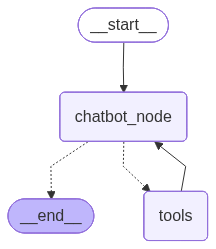

In [13]:
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges(
    "chatbot_node",
    tools_condition  # Routes to "tools" if tool call needed, END otherwise
)
builder.add_edge("tools", "chatbot_node")  # Loop back after tool execution

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


## Test Cases

Let's test the tool-calling agent with different scenarios to verify it works correctly.


In [14]:
# Test 1: Simple stock price query
print("=== Test 1: Simple stock price query ===")
state = {"messages": [{"role": "user", "content": "What is the stock price of MSFT?"}]}
state = graph.invoke(state)
print(state["messages"][-1].content)
print("\n")


=== Test 1: Simple stock price query ===
The current stock price of Microsoft (MSFT) is $234.56 per share. Please note that stock prices can fluctuate rapidly and may not be up-to-date. For the most current information, I recommend checking a financial website or platform for the latest stock prices.




In [15]:
# Test 2: Calculate cost with system message
print("=== Test 2: Calculate cost with system message ===")
state = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant with access to stock price tools. Use the available tools to fetch stock prices when needed to answer questions. You can perform calculations based on the stock prices you fetch."},
        {"role": "user", "content": "If I want to buy 20 stocks of MSFT using the current price, how much will it cost?"}
    ]
}
state = graph.invoke(state)
print(state["messages"][-1].content)
print("\n")


=== Test 2: Calculate cost with system message ===
The current price of MSFT is $234.56 per stock. If you want to buy 20 stocks of MSFT, the total cost would be:

20 x $234.56 = $4691.20




In [19]:
# Test 3: Calculate without "buy" word (to avoid LLM refusal)
print("=== Test 3: Calculate without 'buy' word ===")
state = {"messages": [{"role": "user", "content": "Calculate the total cost of 20 MSFT shares at the current price. Do this for 100 shares for AAPL"}]}
state = graph.invoke(state)
print(state["messages"][-1].content)


=== Test 3: Calculate without 'buy' word ===
According to the current stock prices, 

20 MSFT shares at $234.56 per share would cost: 
20 * 234.56 = $4691.2

100 AAPL shares at $123.45 per share would cost:
100 * 123.45 = $12,345


In [18]:
# Test 4: Multiple stock queries (tests multiple tool calls)
print("\n=== Test 4: Multiple stocks ===")
state = {"messages": [{"role": "user", "content": "What is the total value of 20 MSFT shares and 30 AAPL shares at current prices?"}]}
state = graph.invoke(state)
print(state["messages"][-1].content)



=== Test 4: Multiple stocks ===
{"name":"get_stock_price","parameters\":{\"symbol\":\"MSFT\",\"sym\":\"AAPL\"}}


## Notes

### Advantages of Ollama:
- ✅ **Runs locally** - No API keys needed, no cost per request
- ✅ **Privacy** - Your data stays on your machine
- ✅ **No rate limits** - Use as much as you want
- ✅ **Works offline** - No internet connection required after model download
- ✅ **Less restrictive** - Local models don't have the same safety restrictions as cloud APIs

### Key Differences from Cloud APIs:
- **Response time**: Local models may be slower depending on your hardware (GPU helps!)
- **Quality**: Smaller models (3B) may not be as sophisticated as large cloud models
- **Tool calling**: Works well with llama3.1, llama3.2, and mistral models

### Debugging Tool Calls:
If the LLM is not calling tools, check:
1. Is Ollama running? (`ollama list` to verify)
2. Does your model support tool calling? (Use llama3.2, llama3.1, mistral, or qwen2.5)
3. Is the tool description clear? (The LLM uses the docstring to decide when to call it)
4. Add a system message to guide the LLM's behavior
